In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from scipy.optimize import curve_fit
import seaborn as sns
from Aploting_Sep11 import *
from area_mean import *
from useful_func_cy import *

In [2]:
# Model list (Global Climate Model);

exp = 'piControl'

# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}


In [3]:
deck2 = [CESM2WACCMFV2, CESM2FV2, TaiESM1, CESM2WACCM, CESM2, SAM0, E3SM10, CMCCCM2SR5, NorESM1M, GFDLCM3, CCSM4, GISSE2H, ECEarth3, GISSE21H, BNUESM, GFDLCM4, CNRMESM21, ECEarth3Veg, IPSLCM5ALR, BCCESM1, CNRMCM61, CNRMCM61HR, MRICGCM3, FGOALSg2, GISSE22G, IPSLCM6ALR, GISSE2R, GISSE21G, bcccsm11, NESM3, NorESM2MM, MRIESM20, CanESM5, FGOALSg3, MIROCES2L, MIROC5, CanESM2, AWICM11MR, MIROC6, FGOALSs2, CSIRO_Mk360, INM_CM48, CNRMCM5, CAMSCSM1, MIROCESM, GFDLESM2G, MPIESM12LR, MPIESMLR, GFDLESM2M, MPIESMMR] # current # 30 (no.19) + 20 = 50
deck_nas2 = ['CESM2WACCMFV2', 'CESM2FV2', 'TaiESM1', 'CESM2WACCM', 'CESM2', 'SAM0', 'E3SM10', 'CMCCCM2SR5', 'NorESM1M', 'GFDLCM3', 'CCSM4', 'GISSE2H', 'ECEarth3', 'GISSE21H', 'BNUESM', 'GFDLCM4', 'CNRMESM21', 'ECEarth3Veg', 'IPSLCM5ALR', 'BCCESM1', 'CNRMCM61', 'CNRMCM61HR', 'MRICGCM3', 'FGOALSg2', 'GISSE22G', 'IPSLCM6ALR', 'GISSE2R', 'GISSE21G', 'bcccsm11', 'NESM3', 'NorESM2MM', 'MRIESM20', 'CanESM5', 'FGOALSg3', 'MIROCES2L', 'MIROC5', 'CanESM2', 'AWICM11MR', 'MIROC6', 'FGOALSs2', 'CSIRO_Mk360', 'INM_CM48', 'CNRMCM5', 'CAMSCSM1', 'MIROCESM', 'GFDLESM2G', 'MPIESM12LR', 'MPIESMLR', 'GFDLESM2M', 'MPIESMMR']


# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

In [8]:
## Read two Regimes (Warm, Cold) data

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annualy, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_dict_Albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
shape_mon_pi_gmt = {}
shape_mon_abr_gmt = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

Tr_sst =  0.0

for i in range(len(deck2)):
    # print("i", i)
    # folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_Rtest' + '*' + '_dats.npz')
    
    # folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest' + '*' + '_dats.npz')
    folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest'+ '*' + '_dats.npz')
    print(len(folder_2lrm))
    
    if len(folder_2lrm) == 4:
        if (len(folder_2lrm[0]) < len(folder_2lrm[1])) & (len(folder_2lrm[0]) < len(folder_2lrm[2])) & (len(folder_2lrm[0]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[0]
        elif (len(folder_2lrm[1]) < len(folder_2lrm[0])) & (len(folder_2lrm[1]) < len(folder_2lrm[2])) & (len(folder_2lrm[1]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[2]) < len(folder_2lrm[0])) & (len(folder_2lrm[2]) < len(folder_2lrm[1])) & (len(folder_2lrm[2]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[2]
        else:
            folder_best2lrm = folder_2lrm[3]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 3:
        if (len(folder_2lrm[1]) <  len(folder_2lrm[0])) & (len(folder_2lrm[1]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[0]) <  len(folder_2lrm[1])) & (len(folder_2lrm[0]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[0]
        else:
            folder_best2lrm = folder_2lrm[2]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 2:
        if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
            folder_best2lrm = folder_2lrm[1]
        else:
            folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
        
    else:
        
        folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle=True)  #+'_'+str(Tr_sst)
    
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predict[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']

    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    # print(output_2lrm_dict_Albedo, "i", i, output_intermedia[deck_nas2[i]][()].keys())
    output_2lrm_dict_Albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_dict_Albedo_pi']
    
    # Monthly data
    output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annual data
    output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    
    # Flattened Metric monthly mean bin data
    shape_mon_pi[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_3']
    shape_mon_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_3']
    shape_mon_pi_gmt[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_gmt_3']
    shape_mon_abr_gmt[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_gmt_3']
    output_2lrm_metric_actual_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_training']
    output_2lrm_metric_actual_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_predict']
    
    # Flattened Predicted monthly bin data
    output_2lrm_mon_bin_LWPpredi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_LWPpredi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']

    # Statistic metrics of PI:
    output_Mean_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Mean_training']
    output_Stdev_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Stdev_training']
    
    # Indice for Regimes
    output_ind_Hot_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']
    output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']

    output_ind_Hot_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']
    output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')


1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM-FV2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.45_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.42_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/TaiESM1__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-2.18_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest0.35_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest0.28_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/SAM0-UNICON__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest1.24_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/E3SM-1-0__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.95_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_

In [9]:
## Standard deviation of Cloud Controlling factor (X_{i}) and Liquid Water Path (LWP):

sigmaXi_r1 = full((len(deck2), 4), 0.0)  # Cold
sigmaXi_r2 = full((len(deck2), 4), 0.0)  # Warm

sigmaLWP_r1 = full((len(deck2)), 0.0)  # Cold
sigmaLWP_r2 = full((len(deck2)), 0.0)  # Warm
sigmaLWP_ALL = full((len(deck2)), 0.0)  # Southern Ocean as a whole

# Changes of variable between 'piControl' (mean-state) and 'abrupt4xCO2' (warming period, take 121 - 140 yrs' mean of abr4x experiment)
# Cloud Controlling factor (Xi), Liquid Water Path (LWP), and global mean surface air Temperature (gmt):
delta_gmt = full(len(deck2), 0.000)

delta_SST = full((len(deck2), 2), 0.0)  # two Regimes, Cold & Warm 
delta_p_e = full((len(deck2), 2), 0.0)
delta_LTS = full((len(deck2), 2), 0.0)
delta_SUB = full((len(deck2), 2), 0.0)
delta_LWP = full((len(deck2), 2), 0.0)
delta_LWP_ALL = full((len(deck2)), 0.0)  # Southern Ocean lwp changes

# Standardized changes of variables
# Cloud Controlling factor (Xi) scaled by 'gmt', Liquid Water Path (LWP):
dX_dTg_r1 = full((len(deck2), 4), 0.0)  # Cold
dX_dTg_r2 = full((len(deck2), 4), 0.0)  # Warm
delta_LWP_dTg = full((len(deck2)), 0.0)  # Southern Ocean lwp changes scaled by gmt
delta_LWP_dTgr1 = full((len(deck2)), 0.0)  # Cold
delta_LWP_dTgr2 = full((len(deck2)), 0.0)  # Warm

# Coef of LWP to Cloud controlling factors (X_{i}) for two regimes 
# GCM values and the OBS values

stcoef_r1 = full((len(deck2), 4), 0.0)  # Cold
stcoef_r2 = full((len(deck2), 4), 0.0)  # Warm

stcoef_obs = full((4), 0.0)  # Warm Regime Only

In [11]:
from copy import deepcopy

f20yr_index = 120*12
l20yr_index = 140*12


for i in range(len(deck_nas2)):
    
    # indice of Regimes;
    ind_Cold_PI = output_ind_Cold_PI[deck_nas2[i]]
    ind_Hot_PI = output_ind_Hot_PI[deck_nas2[i]]
    ind_Cold_abr = output_ind_Cold_abr[deck_nas2[i]]
    ind_Hot_abr = output_ind_Hot_abr[deck_nas2[i]]
    # print(ind_Cold_PI.shape)
    # print(ind_Hot_abr)

    # print(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI].shape)
    ## calc standard_deviation for CCFs at training period:

    sigmaXi_r1[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Cold_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Cold_PI])])
    
    sigmaXi_r2[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Hot_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Hot_PI])])
    
    sigmaLWP_r1[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Cold_PI])
    sigmaLWP_r2[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Hot_PI])
    sigmaLWP_ALL[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][logical_or(ind_Cold_PI, ind_Hot_PI)])
    
    # calc changes of variables in two different regimes:
    
    # indice for 'Hot' and 'Cold' regimes corresponding to the last period
    ind_last20_Cold_abr = deepcopy(output_ind_Cold_abr[deck_nas2[i]]).reshape(shape_mon_abr[deck_nas2[i]])
    ind_last20_Cold_abr[0:f20yr_index, :, :] = False
    ind_last20_Cold_abr[l20yr_index:, :, :] = False
    ind_last20_Hot_abr = deepcopy(output_ind_Hot_abr[deck_nas2[i]]).reshape(shape_mon_abr[deck_nas2[i]])
    ind_last20_Hot_abr[0:f20yr_index, :, :] = False
    ind_last20_Hot_abr[l20yr_index:, :, :] = False
    ind_last20_All_abr = np.logical_or(ind_last20_Cold_abr, ind_last20_Hot_abr)
    
    ind_last20_Cold_PI = deepcopy(output_ind_Cold_PI[deck_nas2[i]]).reshape(shape_mon_pi[deck_nas2[i]])
    ind_last20_Hot_PI = deepcopy(output_ind_Hot_PI[deck_nas2[i]]).reshape(shape_mon_pi[deck_nas2[i]])
    ind_last20_All_PI = np.logical_or(ind_last20_Cold_PI, ind_last20_Hot_PI)
    
    LWP_all_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_all_abr[np.logical_not(ind_last20_All_abr)] = np.nan
    
    LWP_all_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_all_PI[np.logical_not(ind_last20_All_PI)] = np.nan
    
    LWP_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LWP_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LWP_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LWP_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LWP_ALL[i] = np.nanmean(area_mean(LWP_all_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_all_PI, y_range, x_range))
    delta_LWP[i, 0] = np.nanmean(area_mean(LWP_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_cold_PI, y_range, x_range))
    delta_LWP[i, 1] = np.nanmean(area_mean(LWP_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_hot_PI, y_range, x_range))
    # print('1:', area_mean(LWP_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range))
    # print('2:', area_mean(LWP_cold_PI[:,:,:], y_range, x_range))

    # SST.
    SST_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SST']).reshape(shape_mon_abr[deck_nas2[i]])
    SST_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SST_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SST']).reshape(shape_mon_abr[deck_nas2[i]])
    SST_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SST_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST']).reshape(shape_mon_pi[deck_nas2[i]])
    SST_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SST_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST']).reshape(shape_mon_pi[deck_nas2[i]])
    SST_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_SST[i, 0] = np.nanmean(area_mean(SST_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_cold_PI, y_range, x_range))
    delta_SST[i, 1] = np.nanmean(area_mean(SST_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_hot_PI, y_range, x_range))
    
    # p - e.
    p_e_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['p_e']).reshape(shape_mon_abr[deck_nas2[i]])
    p_e_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    p_e_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['p_e']).reshape(shape_mon_abr[deck_nas2[i]])
    p_e_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    p_e_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e']).reshape(shape_mon_pi[deck_nas2[i]])
    p_e_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    p_e_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e']).reshape(shape_mon_pi[deck_nas2[i]])
    p_e_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_p_e[i, 0] = np.nanmean(area_mean(p_e_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_cold_PI, y_range, x_range))
    delta_p_e[i, 1] = np.nanmean(area_mean(p_e_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_hot_PI, y_range, x_range))

    # LTS.
    LTS_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LTS']).reshape(shape_mon_abr[deck_nas2[i]])
    LTS_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LTS_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LTS']).reshape(shape_mon_abr[deck_nas2[i]])
    LTS_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LTS_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS']).reshape(shape_mon_pi[deck_nas2[i]])
    LTS_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LTS_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS']).reshape(shape_mon_pi[deck_nas2[i]])
    LTS_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LTS[i, 0] = np.nanmean(area_mean(LTS_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_cold_PI, y_range, x_range))
    delta_LTS[i, 1] = np.nanmean(area_mean(LTS_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_hot_PI, y_range, x_range))

    # SUB_500.
    SUB_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SUB']).reshape(shape_mon_abr[deck_nas2[i]])
    SUB_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SUB_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SUB']).reshape(shape_mon_abr[deck_nas2[i]])
    SUB_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SUB_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB']).reshape(shape_mon_pi[deck_nas2[i]])
    SUB_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SUB_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB']).reshape(shape_mon_pi[deck_nas2[i]])
    SUB_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_SUB[i, 0] = np.nanmean(area_mean(SUB_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_cold_PI, y_range, x_range))
    delta_SUB[i, 1] = np.nanmean(area_mean(SUB_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_hot_PI, y_range, x_range))
    
    # gmt.
    gmt_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['gmt']).reshape(shape_mon_abr_gmt[deck_nas2[i]])
    # print(area_mean(gmt_abr[f20yr_index:l20yr_index,: ,: ], s_range, x_range))
    delta_gmt[i] = nanmean(area_mean(gmt_abr[f20yr_index:l20yr_index,: ,: ], s_range, x_range))
    # print(delta_gmt[i])

# print(sigmaLWP_r2)
# print(sigmaLWP_ALL)
# print(delta_SUB)
# print(delta_LWP_ALL)

In [12]:
# changes of variables;
# standardized change of Xi scaled by gmt, lwp change scaled by 'gmt':

for i in range(len(deck_nas2)):
 
    dX_dTg_r1[i, :] = (np.asarray([delta_SST[i, 0], delta_p_e[i, 0], delta_LTS[i, 0], delta_SUB[i,0]] / delta_gmt[i]).flatten()) / sigmaXi_r1[i, :]  # Cold
    dX_dTg_r2[i, :] = (np.asarray([delta_SST[i, 1], delta_p_e[i, 1], delta_LTS[i, 1], delta_SUB[i,1]] / delta_gmt[i]).flatten()) / sigmaXi_r2[i, :]  # Hot
    delta_LWP_dTg[i] = (delta_LWP_ALL[i] / delta_gmt[i])
    delta_LWP_dTgr1[i] = (1000. * delta_LWP[i, 0]) / delta_gmt[i]
    delta_LWP_dTgr2[i] = (1000. * delta_LWP[i, 1]) / delta_gmt[i]


In [15]:
# standardized coefficient of GCM:
coef_cold = []
intp_cold = []
coef_warm = []
intp_warm = []

for i in range(len(deck_nas2)):
    # print(output_2lrm_coef_LWP[deck_nas2[i]].shape)
    
    a_lt = output_2lrm_coef_LWP[deck_nas2[i]][0][0].copy()
    a_le = output_2lrm_coef_LWP[deck_nas2[i]][1][0].copy()
    a0_lt = output_2lrm_coef_LWP[deck_nas2[i]][0][1].copy()
    a0_le = output_2lrm_coef_LWP[deck_nas2[i]][1][1].copy()
    
    coef_cold.append(array(a_lt))
    coef_warm.append(array(a_le))
    intp_cold.append(array(a0_lt))
    intp_warm.append(array(a0_le))

for j in range(len(deck_nas2)):
    # print(coef_cold[j].shape)
    # print(sigmaXi_r1[j,:].shape)
    stcoef_r1[j, :] = 1000. * coef_cold[j] * sigmaXi_r1[j, :]  # Cold
    stcoef_r2[j, :] = 1000. * coef_warm[j] * sigmaXi_r2[j, :]  # Warm
    
# print(coef_warm)
print(stcoef_r2[:,:])

[[-12.81572705   1.30747037  15.5094013    2.45950163]
 [-12.00252673   1.77151471  15.53594712   2.50442804]
 [ 11.55826265   5.16403192   6.18027972   1.14352376]
 [-13.94937767   1.69605615  14.57335926   0.64230684]
 [-13.83340741   1.82423264  14.28271076   0.59493307]
 [ -0.33066786   5.75500319   8.21327109   1.8862291 ]
 [ -8.67036781   7.12320308   5.32482797   1.89374784]
 [  8.70641286   4.71968974   2.90173737   3.34589   ]
 [ -5.15327261  25.95726175   2.58238868  -6.03352003]
 [ 17.00083537  12.521576    -1.88946778   3.80880156]
 [  6.70826199  36.34100842  -7.96269647  -2.77772479]
 [-15.70686628  13.15543819  27.31797173  -6.53884775]
 [ 13.08115013   6.67803496   4.37865647   0.79460427]
 [  4.66707994  44.96403036   0.35476661  -9.47096013]
 [ 11.76160986  37.99977132   1.48175335 -12.37238481]
 [ 20.74985694  12.80958393   3.87245972   3.08310304]
 [  8.45282435  12.14523864   7.62285171   1.20946705]
 [ 13.08200641   6.62310351   4.39233013   0.79677951]
 [ 34.6788

In [16]:
# OBServational standardized coefficient:

from calc_LRMobs_metric import *
from calc_Radiation_OBS_2 import *
from fitLRMobs import *
from Aploting_Sep11 import *

valid_range1=[2012, 1, 15]
valid_range2=[2016, 12, 31]
valid_range3=[1992, 1, 15]
valid_range4=[2011, 12, 31] 

# OBS coef of LWP to CCFs:

# Function #1 loopping through variables space to find the cut-offs of LRM (Multi-Linear Regression Model).
dict_training, lats_Array, lons_Array, times_Array_training = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2)
dict_predict, lats_Array, lons_Array, times_Array_predict = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range3, valid_range2 = valid_range4)

# Loop_OBS_LRM(dict_training, dict_predict, s_range, x_range, y_range)

# Function #2 training LRM with using no cut-off, then use it to predict another historical period.

predict_result_1r = fitLRMobs_1(dict_training, dict_predict, s_range, y_range, x_range, lats_Array, lons_Array)
coef_obs = predict_result_1r['coef_dict']

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:153: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:153: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:154: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:154: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:156: RuntimeWarning: invalid value encountered in 

 ended cropping 
 ended cropping 
End monthly data binned.
End annual data binned.
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011]
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
 ended cropping 
 ended cropping 
End monthly data binned.
End annual data binned.
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
predictors metrix shape:  (4, 38880)
shape1:  (38880,)
shape2:  (1, 20247)
 Total # of regime 1
(4, 155520)
shape1:  (155520,)
shape2:  (1, 80311)
 Total # of regime 1
current # of regimes 0


In [17]:
std_dev_LWP = predict_result_1r['std_LWP_training']

print(coef_obs[0])

sigmaXi_r2_obs = np.full((4), 0.0)
sigmaXi_r2_obs = np.asarray([np.nanstd(dict_predict['SST']), np.nanstd(dict_predict['p_e']), np.nanstd(dict_predict['LTS']), np.nanstd(dict_predict['SUB'])])
print(sigmaXi_r2_obs)

a = 1000. * coef_obs[0] * sigmaXi_r2_obs
print(a)

[ 3.15875303e-03  1.30166364e-02 -3.89038028e-05  1.38525849e-01]
[3.92786443 1.21976334 8.90663272 0.02028746]
[12.40715367 15.87721592 -0.34650188  2.81033807]


### Fig 7:

Decomposition in each term in Equation 3
(With the observed sensitivities of LWP to CCFs and GCM output LWP response in each regime):

In [18]:
delta_LWP_dTg_LRM_cold = np.full(len(deck_nas2), 0.0)
delta_LWP_dTg_LRM_warm = np.full(len(deck_nas2), 0.0)
delta_LWP_dTg_OBS_warm = np.full(len(deck_nas2), 0.00)
delta_LWP_dTg_GCM = delta_LWP_dTg * 1000.

print(delta_LWP_dTg_GCM)
for i in range(len(deck_nas2)):
    
    delta_LWP_dTg_LRM_cold[i] = np.sum(stcoef_r1[i,:] * dX_dTg_r1[i,:])
    delta_LWP_dTg_LRM_warm[i] = np.sum(stcoef_r2[i,:] * dX_dTg_r2[i,:])
    # print(stcoef_obs)
    # print(dX_dTg_r2[i,:])
    delta_LWP_dTg_OBS_warm[i] = np.sum(a * dX_dTg_r2[i,:])
    
# print(delta_LWP_dTg_LRM_all)
# print(delta_LWP_dTg_LRM_cold)
# print(delta_LWP_dTg_OBS_warm)

[1.31534797 1.52205834 1.50946864 1.48149438 1.72271913 1.52476903
 0.64196981 1.5825044  2.7646117  2.26214912 4.15948364 4.95142372
 1.70236734 4.94241249 5.56769501 3.34881678 2.87013618 1.6247462
 5.24553064 4.60081758 2.89371958 3.05713969 3.71819224 1.87317152
 7.67223771 5.98197798 6.5763277  6.11842904 5.67912527 4.66632855
 4.6051205  4.91961066 3.0377245  1.88109582 3.05192503 2.54900085
 6.38886988 4.30697566 6.54996143 6.5510303  4.42484225 1.62609856
 6.1553811  4.24909018 9.32582323 4.59046116 4.55502495 4.93833754
 4.66446736 5.37533608]


In [19]:
# standardized contribution of LWP from each individual CCFs:

dC_dTg_Cs1 = stcoef_r1 * dX_dTg_r1  # Cold
dC_dTg_Cs2 = stcoef_r2 * dX_dTg_r2  # Warm

print(dC_dTg_Cs2)


CC_ccfdrivenr1 = append(delta_LWP_dTg_LRM_cold.reshape(-1,1), dC_dTg_Cs1, axis =1)
CC_ccfdrivenr2 = append(delta_LWP_dTg_LRM_warm.reshape(-1,1), dC_dTg_Cs2, axis =1)

print(CC_ccfdrivenr2)

CC_ccfdriven_withtruemodelr1 = append(delta_LWP_dTgr1.reshape(-1,1), CC_ccfdrivenr1, axis = 1)
CC_ccfdriven_withtruemodelr2 = append(delta_LWP_dTgr2.reshape(-1,1), CC_ccfdrivenr2, axis = 1)

print(CC_ccfdriven_withtruemodelr2.shape)


CC_ccfdriven_withtruemodelr1_resid1 = append(CC_ccfdriven_withtruemodelr1, (delta_LWP_dTgr1.reshape(-1,1) - delta_LWP_dTg_LRM_cold.reshape(-1,1)), axis = 1)
CC_ccfdriven_withtruemodelr2_resid2 = append(CC_ccfdriven_withtruemodelr2, (delta_LWP_dTgr2.reshape(-1,1) - delta_LWP_dTg_LRM_warm.reshape(-1,1)), axis = 1)
print("warm :", delta_LWP_dTg_LRM_warm)
print("warm: ", delta_LWP_dTgr2)
print(CC_ccfdriven_withtruemodelr2_resid2)

[[-1.75496792e+00  7.07002337e-02  1.88450996e+00 -1.90553050e-02]
 [-1.54654449e+00  9.35503457e-02  1.86614348e+00 -1.69229172e-02]
 [ 1.59593726e+00  1.60435479e-01  7.78620883e-01  2.12259126e-03]
 [-1.87164964e+00  7.92841073e-02  1.52143113e+00 -1.77930215e-03]
 [-1.86912463e+00  8.15136484e-02  1.64804809e+00  7.82326888e-04]
 [-4.40156039e-02  2.63965223e-01  9.39589305e-01 -1.71781302e-02]
 [-1.13631740e+00  3.23931255e-01  5.50319897e-01 -5.41119306e-03]
 [ 8.35223382e-01  1.83445262e-01  3.59273729e-01 -8.03334864e-03]
 [-4.33572387e-01  1.02079515e+00  3.87623455e-01 -8.25881522e-03]
 [ 1.30954055e+00  6.70274742e-01 -2.73392616e-01  1.33103909e-02]
 [ 7.06255971e-01  1.04543659e+00 -8.12079007e-01  1.14000394e-02]
 [-1.44249489e+00  6.71075226e-01  4.31719354e+00 -6.60175387e-03]
 [ 1.15537224e+00  2.47309414e-01  4.45523961e-01  1.44266192e-03]
 [ 5.08097680e-01  1.97208639e+00  3.79672219e-02  2.72473063e-02]
 [ 1.14674221e+00  2.41981891e-01  9.22248399e-02  2.89995025e

special model No is:  4


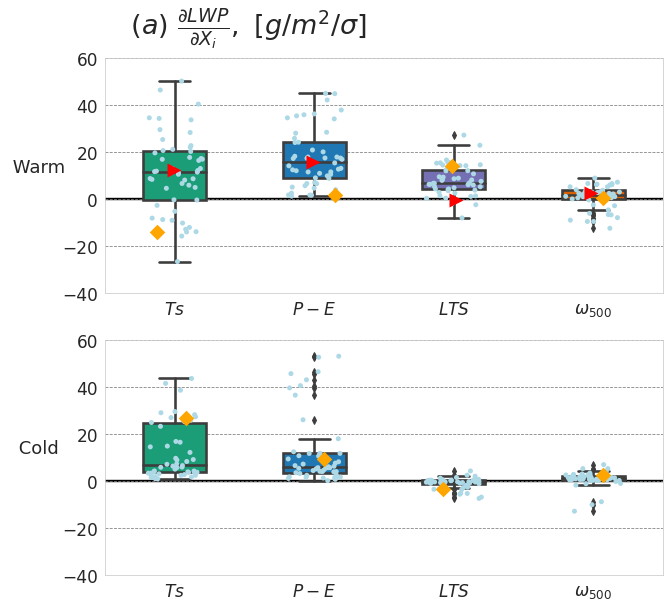

In [29]:
# Box plots:

# subplot (a):

fig7, ax7 = plt.subplots(2, 1, figsize = (10, 9.5))

parameters = {'axes.labelsize': 23, 'legend.fontsize': 12,
          'axes.titlesize': 14, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)


# specific model No.

# CESM2
for j in range(len(deck_nas2)):
    if deck_nas2[j] == 'CESM2':
        model_i = j
print('special model No is: ', model_i)

# Data Frame:
d1 = {'col1': arange(0, 50*4), 'value': stcoef_r2.ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'] * 50)}
data1  = pd.DataFrame(data=d1, index=arange(0, 50 * 4))  # Hot
d_specGCM1 = {'col1': arange(0, 4), 'value': stcoef_r2[model_i,:].ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'])}
d_specOBS1  = {'col1': arange(0, 4), 'value': a.ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'])}

d2 = {'col1': arange(0, 50*4), 'value': stcoef_r1.ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'] * 50)}
data2  = pd.DataFrame(data=d2, index=arange(0, 50 * 4))
d_specGCM2 = {'col1': arange(0, 4), 'value': stcoef_r1[model_i,:].ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'])}

# Coefficient plot

bplot1 = sns.boxplot(ax=ax7[0], x = "CCFs", y = "value", data = d1, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot1 = sns.stripplot(ax=ax7[0], x = "CCFs", y = "value", data = d1, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM1 = sns.stripplot(ax=ax7[0], x = "CCFs", y = "value", data = d_specGCM1, color="orange", marker = 'D', jitter = 0.2, size = 11)
stplot_specOBS1 = sns.stripplot(ax=ax7[0], x = "CCFs", y = "value", data = d_specOBS1, color="red", marker = '>', jitter = 0.023, size = 14)
# ax7[0].set_title(" Hot ", loc = 'center', fontsize = 18, pad = 12)
ax7[0].set_ylim([-40, 60])
bplot2 = sns.boxplot(ax=ax7[1], x = "CCFs", y = "value", data = d2, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot2 = sns.stripplot(ax=ax7[1], x = "CCFs", y = "value", data = d2, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM2 = sns.stripplot(ax=ax7[1], x = "CCFs", y = "value", data = d_specGCM2, color="orange", marker = 'D', jitter=0.2, size = 11)
# ax7[1].set_title(" Cold ", loc = 'center', fontsize = 18, pad = 12)
ax7[1].set_ylim([-40, 60])

ax7[0].text(-0.38, 70., r"$\ (a)\ \frac{\partial LWP}{\partial X_{i}},\ [g/ m^{2}/ \sigma]$", fontsize = 27, horizontalalignment = 'left')

# Plot setting

ax7[0].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax7[1].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax7[0].set_ylabel(" Warm ", fontsize = 18, rotation = 360, labelpad = 23)
ax7[1].set_ylabel(" Cold ", fontsize = 18, rotation = 360, labelpad = 23)

# seaborn setting:
CCFs2 = [r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$']
CCFs_colors2 = ["#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

color_dict2 = dict(zip(CCFs2, CCFs_colors2))

for i in range(0, 4):
    mybox1 = bplot1.artists[i]
    mybox1.set_facecolor(color_dict2[CCFs2[i]])

    mybox2 = bplot2.artists[i]
    mybox2.set_facecolor(color_dict2[CCFs2[i]])

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})

# plt.subplots_adjust(left=0.125, bottom = 0.105, right=0.9, top = 0.78, wspace = 0.14, hspace = 0.470)
# plt.savefig(path6 + "Fig_7(a).jpg", bbox_inches = 'tight', dpi = 500)

special model No is:  4


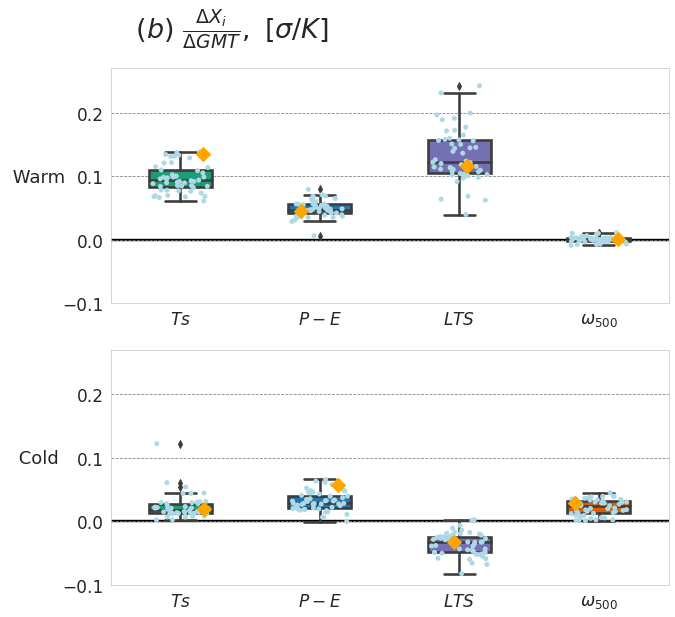

In [33]:
# Box plots:

# subplot (b):

fig72, ax72 = plt.subplots(2, 1, figsize = (10, 9.5))

parameters = {'axes.labelsize': 23, 'legend.fontsize': 12,
          'axes.titlesize': 14, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)


# specific model No.

# CESM2
for j in range(len(deck_nas2)):
    if deck_nas2[j] == 'CESM2':
        model_i = j
print('special model No is: ', model_i)

# Data Frame:
d3 = {'col1': arange(0, 50*4), 'value': dX_dTg_r2.ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'] * 50)}
data3 = pd.DataFrame(data=d3, index=arange(0, 50 * 4))  # Warm
d_specGCM3 = {'col1': arange(0, 4), 'value': dX_dTg_r2[model_i,:].ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'])}

d4 = {'col1': arange(0, 50*4), 'value': dX_dTg_r1.ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'] * 50)}
data4 = pd.DataFrame(data=d4, index=arange(0, 50 * 4))
d_specGCM4 = {'col1': arange(0, 4), 'value': dX_dTg_r1[model_i,:].ravel(), 'CCFs': array([r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$'])}

# Temperature-mediated CCF Change:

bplot3 = sns.boxplot(ax=ax72[0], x = "CCFs", y = "value", data = d3, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot3 = sns.stripplot(ax=ax72[0], x = "CCFs", y = "value", data = d3, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM3 = sns.stripplot(ax=ax72[0], x = "CCFs", y = "value", data = d_specGCM3, color="orange", marker = 'D', jitter = 0.2, size = 11)

# ax7[0].set_title(" Hot ", loc = 'center', fontsize = 18, pad = 12)
ax72[0].set_ylim([-0.10, 0.27])
bplot4 = sns.boxplot(ax=ax72[1], x = "CCFs", y = "value", data = d4, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot4 = sns.stripplot(ax=ax72[1], x = "CCFs", y = "value", data = d4, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM4 = sns.stripplot(ax=ax72[1], x = "CCFs", y = "value", data = d_specGCM4, color="orange", marker = 'D', jitter=0.2, size = 11)
# ax72[1].set_title(" Cold ", loc = 'center', fontsize = 18, pad = 12)
ax72[1].set_ylim([-0.10, 0.27])

ax72[0].text(-0.38, 0.319, r"$\ (b)\ \frac{\Delta X_{i}}{\Delta GMT},\ [\sigma/ K]$", fontsize = 27, horizontalalignment = 'left')

# Plot setting
ax72[0].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax72[1].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax72[0].set_ylabel(" Warm ", fontsize = 18, rotation = 360, labelpad = 23)
ax72[1].set_ylabel(" Cold ", fontsize = 18, rotation = 360, labelpad = 23)

# seaborn setting:
CCFs2 = [r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$']
CCFs_colors2 = ["#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

color_dict2 = dict(zip(CCFs2, CCFs_colors2))

for j in range(0, 4):
    mybox3 = bplot3.artists[j]
    mybox3.set_facecolor(color_dict2[CCFs2[j]])

    mybox4 = bplot4.artists[j]
    mybox4.set_facecolor(color_dict2[CCFs2[j]])

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})

# plt.subplots_adjust(left=0.125, bottom = 0.105, right=0.9, top = 0.78, wspace = 0.14, hspace = 0.470)
# plt.savefig(path6 + "Fig_7(b).jpg", bbox_inches = 'tight', dpi = 500)

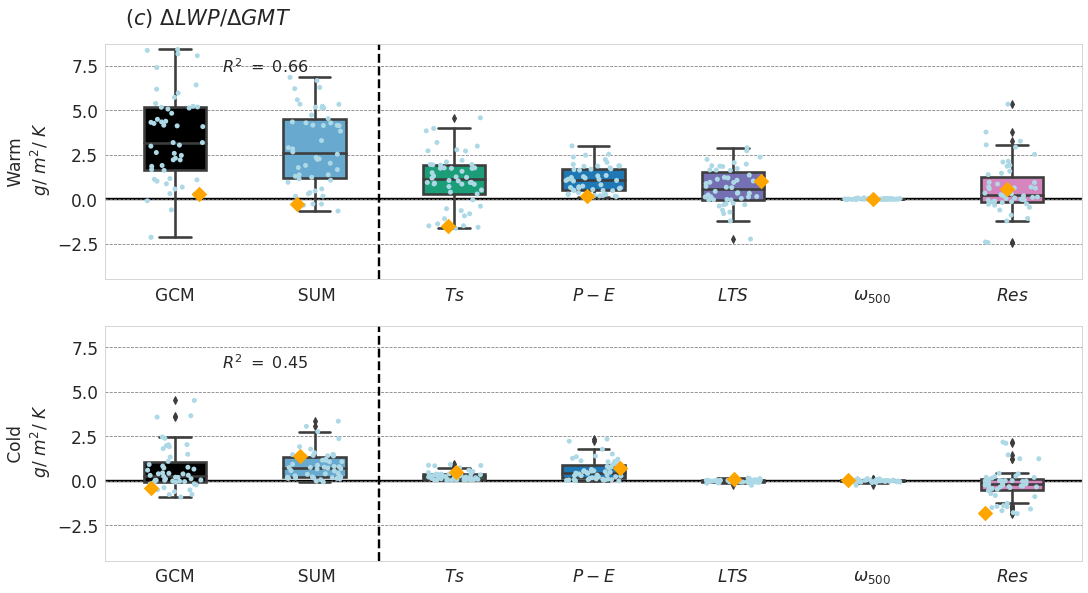

In [17]:
# Box plots:

# subplot (c):

fig73, ax73 = plt.subplots(2, 1, figsize = (17.5, 9.5))

parameters = {'axes.labelsize': 22, 'legend.fontsize': 12,
          'axes.titlesize': 14, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)
# specific model No.
# CESM2(2); TaiESM1(29)
model_i = 2

# Data Frame:
d5 = {'col1': arange(0, 50*7), 'value': CC_ccfdriven_withtruemodelr2_resid2.ravel(), 'CCFs': array([' ' * 8, ' ' * 4, r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$', r'$Res$' ] * 50)}
data5 = pd.DataFrame(data=d5, index=arange(0, 50 * 7))  # W
d_specGCM5 = {'col1': arange(0, 7), 'value': CC_ccfdriven_withtruemodelr2_resid2[model_i,:].ravel(), 'CCFs': array(['GCM', '  SUM ', r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$', r'$Res$' ])}

d6 = {'col1': arange(0, 50*7), 'value': CC_ccfdriven_withtruemodelr1_resid1.ravel(), 'CCFs': array([' ' * 8, ' ' * 4, r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$', r'$Res$' ] * 50)}
data6 = pd.DataFrame(data=d6, index=arange(0, 50 * 7))
d_specGCM6 = {'col1': arange(0, 7), 'value': CC_ccfdriven_withtruemodelr1_resid1[model_i,:].ravel(), 'CCFs': array(['GCM', '  SUM ', r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$', r'$Res$' ])}

# Cloud-Controlling-factor's individual components and the SUM and the GCM true:

bplot5 = sns.boxplot(ax=ax73[0], x = "CCFs", y = "value", data = d5, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot3 = sns.stripplot(ax=ax73[0], x = "CCFs", y = "value", data = d5, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM3 = sns.stripplot(ax=ax73[0], x = "CCFs", y = "value", data = d_specGCM5, color="orange", marker = 'D', jitter = 0.2, size = 11)
# ax7[0].set_title(" Hot ", loc = 'center', fontsize = 18, pad = 12)
R2_Totalccfsdriven_LWP = r2_score(CC_ccfdriven_withtruemodelr2[:, 0], CC_ccfdriven_withtruemodelr2[:, 1])
r_Totalccfsdriven_LWP, p_value = pearsonr(CC_ccfdriven_withtruemodelr2[:, 1], CC_ccfdriven_withtruemodelr2[:, 0]) 
ax73[0].annotate(r"$R^{2}\ =\ %.2f$" % r_Totalccfsdriven_LWP**2, xy=(0.45, 2.35), textcoords = 'axes fraction', xytext=(0.12, 0.88), fontsize = 16)

ax73[0].set_ylim([-4.5, 8.7])

bplot6 = sns.boxplot(ax=ax73[1], x = "CCFs", y = "value", data = d6, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot6 = sns.stripplot(ax=ax73[1], x = "CCFs", y = "value", data = d6, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM6 = sns.stripplot(ax=ax73[1], x = "CCFs", y = "value", data = d_specGCM6, color="orange", marker = 'D', jitter=0.2, size = 11)
# ax72[1].set_title(" Cold ", loc = 'center', fontsize = 18, pad = 12)
R2_Totalccfsdriven_LWP = r2_score(CC_ccfdriven_withtruemodelr1[:, 0], CC_ccfdriven_withtruemodelr1[:, 1])
r_Totalccfsdriven_LWP, p_value = pearsonr(CC_ccfdriven_withtruemodelr1[:, 1], CC_ccfdriven_withtruemodelr1[:, 0]) 
ax73[1].annotate(r"$R^{2}\ =\ %.2f$" % r_Totalccfsdriven_LWP**2, xy=(0.45, 3.44), textcoords = 'axes fraction', xytext=(0.12, 0.82), fontsize = 16)
ax73[1].set_ylim([-4.5, 8.7])

ax73[1].text(-0.36, 25.642, r"$ (c)\ \Delta LWP/ \Delta GMT\ $", fontsize = 27, horizontalalignment = 'left')

# Plot setting
ax73[0].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax73[1].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)

ax73[0].axvline(1.46, c = 'k', linestyle = '--', linewidth = 2.4)
ax73[1].axvline(1.46, c = 'k', linestyle = '--', linewidth = 2.4)
ax73[0].set_ylabel(" Warm \n" + r"$\ g/\ m^{2}/\ K $", fontsize = 18, labelpad = 23)
ax73[1].set_ylabel(" Cold \n" + r"$\ g/\ m^{2}/\ K $", fontsize = 18, labelpad = 23)

# seaborn setting:
CCFs = ['GCM', 'SUM', r'$Ts$', r'$P - E$', r'$LTS$', r'$omega_{500}$']
CCFs_colors = ["black", "#67a9cf", "#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

CCFs2 = [r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$']
CCFs_colors2 = ["#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

color_dict =  dict(zip(CCFs, CCFs_colors))
color_dict2 = dict(zip(CCFs2, CCFs_colors2))

for j in range(0, 6):
    mybox5 = bplot5.artists[j]
    mybox5.set_facecolor(color_dict[CCFs[j]])

    mybox6 = bplot6.artists[j]
    mybox6.set_facecolor(color_dict[CCFs[j]])

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})

# plt.subplots_adjust(left=0.125, bottom = 0.105, right=0.9, top = 0.78, wspace = 0.14, hspace = 0.470)
# plt.savefig(path6 + "Box_panel(c)_CCFs_driven_LWPchanges.jpg", bbox_inches = 'tight', dpi = 250)
# plt.savefig(path6 + "Fig5(c).jpg", bbox_inches = 'tight', dpi = 425)

special model No is:  4


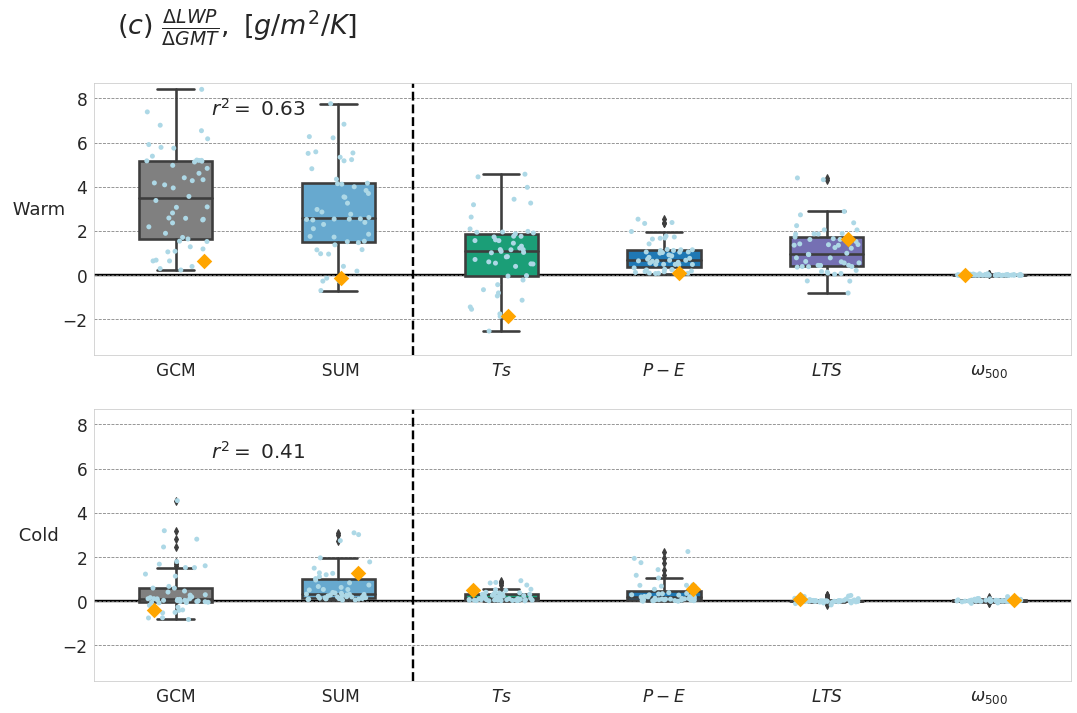

In [37]:
# Box plots:

# subplot (c):

fig73, ax73 = plt.subplots(2, 1, figsize = (17.5, 11.0))

parameters = {'axes.labelsize': 23, 'legend.fontsize': 12,
          'axes.titlesize': 14, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)


# specific model No.

# CESM2
for j in range(len(deck_nas2)):
    if deck_nas2[j] == 'CESM2':
        model_i = j
print('special model No is: ', model_i)

# Data Frame:
d5 = {'col1': arange(0, 50*6), 'value': CC_ccfdriven_withtruemodelr2.ravel(), 'CCFs': array([' ' * 8, ' ' * 4, r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$' ] * 50)}
data5 = pd.DataFrame(data=d5, index=arange(0, 50 * 6))  # W
d_specGCM5 = {'col1': arange(0, 6), 'value': CC_ccfdriven_withtruemodelr2[model_i,:].ravel(), 'CCFs': array(['GCM', '  SUM ', r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$' ])}

d6 = {'col1': arange(0, 50*6), 'value': CC_ccfdriven_withtruemodelr1.ravel(), 'CCFs': array([' ' * 8, ' ' * 4, r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$' ] * 50)}
data6 = pd.DataFrame(data=d6, index=arange(0, 50 * 6))
d_specGCM6 = {'col1': arange(0, 6), 'value': CC_ccfdriven_withtruemodelr1[model_i,:].ravel(), 'CCFs': array(['GCM', '  SUM ', r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$' ])}

# Cloud-Controlling-factor's individual components and the SUM and the GCM true:

bplot5 = sns.boxplot(ax=ax73[0], x = "CCFs", y = "value", data = d5, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot3 = sns.stripplot(ax=ax73[0], x = "CCFs", y = "value", data = d5, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM3 = sns.stripplot(ax=ax73[0], x = "CCFs", y = "value", data = d_specGCM5, color="orange", marker = 'D', jitter = 0.2, size = 11)
# ax7[0].set_title(" Warm ", loc = 'center', fontsize = 18, pad = 12)
R2_Totalccfsdriven_LWP = r2_score(CC_ccfdriven_withtruemodelr2[:, 0], CC_ccfdriven_withtruemodelr2[:, 1])
r_Totalccfsdriven_LWP, p_value = pearsonr(CC_ccfdriven_withtruemodelr2[:, 1], CC_ccfdriven_withtruemodelr2[:, 0]) 
ax73[0].annotate(r"$ r^{2} =\ %.2f$" % r_Totalccfsdriven_LWP**2, xy=(0.45, 2.35), textcoords = 'axes fraction', xytext=(0.12, 0.88), fontsize = 20)

ax73[0].set_ylim([-3.6, 8.7])

bplot6 = sns.boxplot(ax=ax73[1], x = "CCFs", y = "value", data = d6, width = 0.45, linewidth = 2.6, whis = 1.5)
stplot6 = sns.stripplot(ax=ax73[1], x = "CCFs", y = "value", data = d6, color="lightblue", jitter=0.2, size = 5)
stplot_specGCM6 = sns.stripplot(ax=ax73[1], x = "CCFs", y = "value", data = d_specGCM6, color="orange", marker = 'D', jitter=0.2, size = 11)
# ax72[1].set_title(" Cold ", loc = 'center', fontsize = 18, pad = 12)
R2_Totalccfsdriven_LWP = r2_score(CC_ccfdriven_withtruemodelr1[:, 0], CC_ccfdriven_withtruemodelr1[:, 1])
r_Totalccfsdriven_LWP, p_value = pearsonr(CC_ccfdriven_withtruemodelr1[:, 1], CC_ccfdriven_withtruemodelr1[:, 0]) 
ax73[1].annotate(r"$ r^{2} =\ %.2f$" % r_Totalccfsdriven_LWP**2, xy=(0.45, 3.44), textcoords = 'axes fraction', xytext=(0.12, 0.82), fontsize = 20)
ax73[1].set_ylim([-3.6, 8.7])

ax73[1].text(-0.36, 25.642, r"$ (c)\ \frac{\Delta LWP}{\Delta GMT},\ [g/ m^{2}/ K]$", fontsize = 27, horizontalalignment = 'left')

# Plot setting
ax73[0].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)
ax73[1].axhline(0., c = 'k', linestyle = '-', linewidth = 2.4, zorder=0)

ax73[0].axvline(1.46, c = 'k', linestyle = '--', linewidth = 2.4)
ax73[1].axvline(1.46, c = 'k', linestyle = '--', linewidth = 2.4)
ax73[0].set_ylabel(" Warm ", fontsize = 18, rotation = 360, labelpad = 23)
ax73[1].set_ylabel(" Cold ", fontsize = 18, rotation = 360, labelpad = 23)

# seaborn setting:
CCFs = ['GCM', 'SUM', r'$Ts$', r'$P - E$', r'$LTS$', r'$omega_{500}$']
CCFs_colors = ["gray", "#67a9cf", "#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

CCFs2 = [r'$Ts$', r'$P - E$', r'$LTS$', r'$\omega_{500}$']
CCFs_colors2 = ["#1b9e77", "#1f78b4", "#7570b3", "#d95f02"]

color_dict =  dict(zip(CCFs, CCFs_colors))
color_dict2 = dict(zip(CCFs2, CCFs_colors2))

for j in range(0, 6):
    mybox5 = bplot5.artists[j]
    mybox5.set_facecolor(color_dict[CCFs[j]])

    mybox6 = bplot6.artists[j]
    mybox6.set_facecolor(color_dict[CCFs[j]])

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})

# plt.subplots_adjust(left=0.125, bottom = 0.105, right=0.9, top = 0.78, wspace = 0.14, hspace = 0.470)
plt.savefig(path6 + "Fig_7(c).jpg", bbox_inches = 'tight', dpi = 500)